# Datasets and Dataloader

Code for processing data samples can get messy and hard to maintain. We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. 

Pytorch has two data primitives:
- dataloader
- dataset

Allows to pre-load datasets as well as your own dataa.

Datasets: stors the samples and there corresponding labels
Dataloader: Wraps an iterable around the dataset to enable easy access to the samples

Pytorch domain libraries provide a number of pre-loaded datasets that subclass and impletement functions specific to particular data. They can be used to prototype and benchmark your model.

## Loading a Dataset

Example of how to load fashion mnist dataset from torchvision. We load the dataset with the following parameters:
- root is the path where the train/test data is stored
- train specifies training or test dataset
- download=true downloads the data from the internet if its not available at root
- tranform and target_transform specify the feature and label tranformations

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset

We can index Dataset manually like a list: training_data[index].
We use matplotlib to visualize some samples in our training data.

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

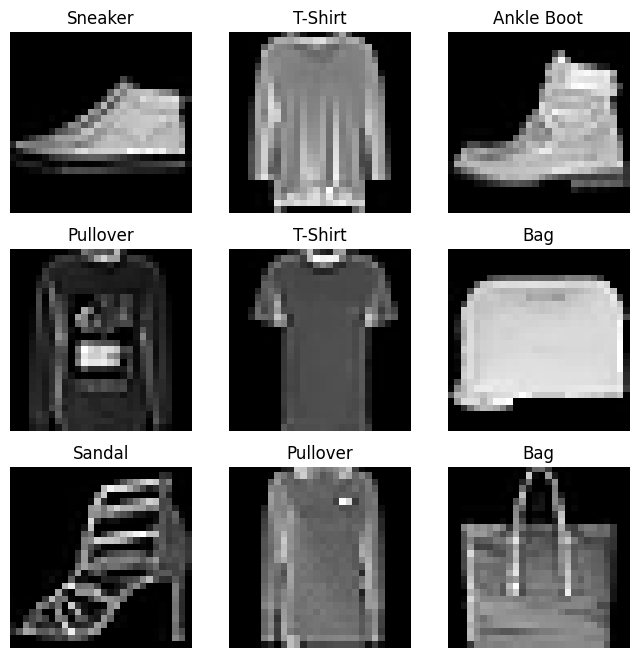

In [6]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files

Cuistom dataset class must implement three functions:
- init
- len
- getitem

The fashionmnist images are stored in directory img_dir, adn their labels are stored separately in csv files

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None,
                 target_tranform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.tranform = transform
        self.target_transform = target_tranform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.tranform:
            image = self.tranform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Init

Runs once when instantiating the dataset object. We initialize the directory condtaining the images, anotations file, and both transforms.

### Len

Returns the number of samples in our dataset

### Getitem

Loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the images location on disk, converts that to a tensor using read_image, retrieves the corresponding label from csv data in img_labels, calls the tranform function on them and returns the tensor image and corresponding label in a truple

## Preparing your data for training with dataloader

The dataset retrieves our datasets feature and labels one sample at a time. While a model, we typically want to pass samples in minibatches, reshuffle the data at every epoch to reduce model overfitting and uses python multiprocessing to speed up data retrieval

Dataloader is an iterable that abstracts this complexity for us in a easy api

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterating through the dataloader

We have loaded that dataset into the dataloader and can iterate through the dataset as needed. Each iteration below return a batch of train_features and train_labels. Because we specified shuffle=true, after we iterate over all batches the data is shuffled

In [10]:
# display image and label

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
labels batch shape: torch.Size([64])


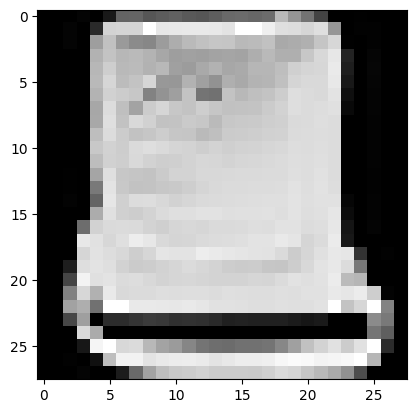

Label: 8


In [11]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")